## **Support Vector Machine**

### The same as before, we are supposed to import some needed libraries

In [25]:
import os
import numpy as np
from skimage import color
from skimage.feature import canny
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
%matplotlib inline

### Getting path to random image stored in *train* directory consisting of folders with different flowers species

In [26]:
path_to_train_directory = './output/train'
path_to_validation_directory = './output/val'
flower_species = ['iris', 'rose', 'sunflower', 'tulip']

path_to_chosen_species_directory = os.path.join(path_to_train_directory, np.random.choice(flower_species)).replace('\\', '/')
random_flower_image_path = os.path.join(path_to_chosen_species_directory, np.random.choice(os.listdir(path_to_chosen_species_directory))).replace('\\', '/')

random_flower_image_path

'./output/train/sunflower/309167784_4fbce0763a_c.jpg'

### Using Pillow to open, resize image and Numpy to convert it into three-dimensional matrix (width, length, rgb)

In [72]:
image_of_random_flower = Image.open(random_flower_image_path) # PIL.JpegImagePlugin.JpegImageFile object
resized_image = image_of_random_flower.resize((64, 128))
matrix_of_resized_image = np.array(resized_image) # numpy array

print(matrix_of_resized_image.shape)

(128, 64, 3)


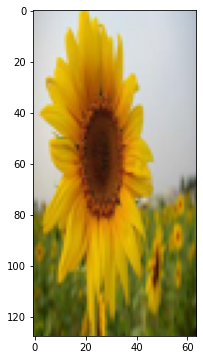

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(resized_image)
plt.show()

## **Different features extractions**

### **HOG Feature Descriptor**

### I was looking for a reliable method which can be used to extract features from images. I am dealing with dozen thousands of photos which every of them is composed of as many pixels as the product of width and the height. In addition, each pixel (for colorful images) is expressed by 3 values (r, g, b), so you can calculate how enormous number of features and amount of numerical data the classifier has to face with. I was browsing some websites and I decided to use HOG - Histogram of oriented gradients. This method is widely decribed here: [Histograms of Oriented Gradients for Human Detection](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf). I know this method was used to detect humans on pictures and its purpose is to detect objects, but I want to try to use it for feature extraction, especially that various species of flowers have different shapes.

In [29]:
from skimage.feature import hog
from skimage import exposure

hog_feature_matrix, hog_image = hog(matrix_of_resized_image,
                                    orientations=9,
                                    pixels_per_cell=(8, 8), 
                                    cells_per_block=(2, 2),
                                    visualize=True,
                                    multichannel=True)

hog_image_rescaled_intensity = exposure.rescale_intensity(hog_image, in_range=(0, 50))

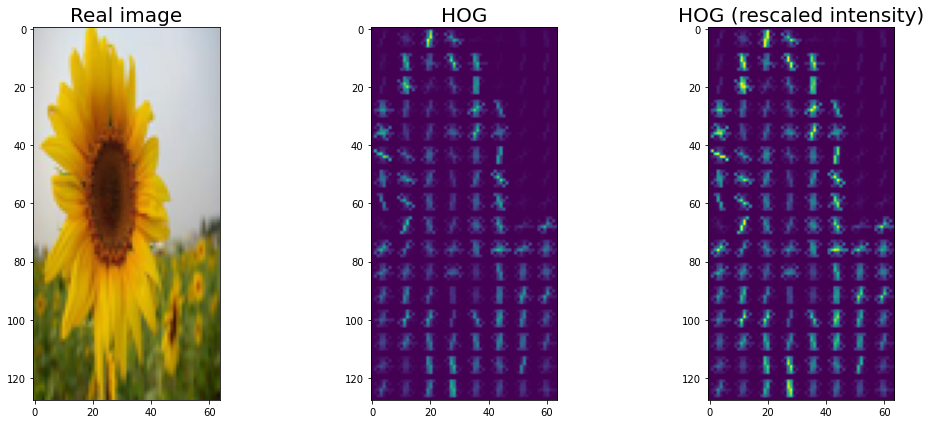

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(resized_image)
axes[1].imshow(hog_image)
axes[2].imshow(hog_image_rescaled_intensity)
ax_set_titles = [axes[i].set_title(title, fontsize=20) for i, title in enumerate(['Real image', 'HOG', 'HOG (rescaled intensity)'])]

plt.tight_layout()
plt.show()

In [31]:
print(f'Number of features for:\n 1. rescaled original photo: {matrix_of_resized_image.size}\n 2. after applying HOG: {hog_feature_matrix.size}')

Number of features for:
 1. rescaled original photo: 24576
 2. after applying HOG: 3780


### Preparing train, validation and test set

In [33]:
X_train, Y_train = [], []

In [34]:
for class_number, species in enumerate(flower_species):

    path_to_species_directory = os.path.join(path_to_train_directory, species).replace('\\', '/')
    
    for file_path in os.listdir(path_to_species_directory):

        whole_imgae_path = os.path.join(path_to_species_directory, file_path).replace('\\', '/')

        image_of_flower = Image.open(whole_imgae_path)
        resized_image = image_of_flower.resize((64, 128)) 
        matrix_of_resized_image = np.array(resized_image)
        matrix_of_resized_image = matrix_of_resized_image / 255 # standarization

        if matrix_of_resized_image.shape != (128, 64, 3):
            continue

        hog_feature_matrix = hog(
                                matrix_of_resized_image,
                                orientations=9, 
                                pixels_per_cell=(8, 8), 
                                cells_per_block=(2, 2),
                                visualize=False,
                                block_norm= 'L2', # images does not have much noise, we can use standard L2 norm
                                multichannel=True
                                )

        X_train += [hog_feature_matrix]
        Y_train += [class_number]

    print(f'{(class_number + 1) * 25} %  completed!') 

25 %  completed!
50 %  completed!
75 %  completed!
100 %  completed!


In [35]:
X_val, Y_val = [], []

for class_number, species in enumerate(flower_species):

    path_to_species_directory = os.path.join(path_to_validation_directory, species).replace('\\', '/')

    for file_path in os.listdir(path_to_species_directory):

        whole_imgae_path = os.path.join(path_to_species_directory, file_path).replace('\\', '/')

        image_of_flower = Image.open(whole_imgae_path)
        resized_image = image_of_flower.resize((64, 128))
        matrix_of_resized_image = np.array(resized_image)
        matrix_of_resized_image = matrix_of_resized_image / 255

        if matrix_of_resized_image.shape != (128, 64, 3):
            continue

        hog_feature_matrix = hog(
                                matrix_of_resized_image,
                                orientations=9,
                                pixels_per_cell=(8, 8), 
                                cells_per_block=(2, 2),
                                visualize=False,
                                block_norm= 'L2', # images does not have much noise, we can use standard L2 norm
                                multichannel=True
                                )

        X_val.append(hog_feature_matrix)
        Y_val.append(class_number)

    print(f'{(class_number + 1) * 25} %  completed!')

25 %  completed!
50 %  completed!
75 %  completed!
100 %  completed!


In [56]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(np.array(X_train), np.array(Y_train))
X_val, Y_val = shuffle(np.array(X_val), np.array(Y_val))

### I am aware of the fact that SVM is not suitable for classification of large data sets, but is my data set really large? 8189 samples and currently I am dealing with 4 classes - I can agree that probably one thousend per class would be enough. I have to also consider that Kernel matrix is increasing quadratically with the number of data points, so that is a big problem.

### But here appears the question - can I take 4 thousands of samples using `X_train[:4000]`? If data is properly shuffled, propability of getting each class should be equal to 1 / `number_of_class` and cardinalities of each class should be equal too.

In [58]:
counter = Counter(Y_train[:4000])
print(counter)

Counter({3: 1041, 1: 1007, 0: 987, 2: 965})


### It looks very appriopriate, classes are balanced

### I will be using SVM with RBF (The Radial Basis Function Kernel). Kernel function allows finding Support Vector Classifieres in higher dimensions systematically. It calculates the relationships between every pair of points as if they are in the higher dimensions, but they do not actually do the transformation - it is called The Kernel Trick. The Kernel Trick reduces the amount of computation required for Support Vector Machines by avoiding the math transforms the data from low to high dimensions. RBF is a kernel function which calculates relationships in the infinite dimensions. It is calculated by taking two different data points:<br>$$e^{\gamma(x_1, x_2)^2}$$ $\gamma$ is determined by Cross Validation and it scales the squared distance between two observations (amount of influence one observation has on another). SVM is a classifier which search for best hyperplane which can divide two classes with the biggest possible margin. Due to this fact, SVM allows missclassification (high bias), but it copes better with new data (low variance). But someone can point that I am not dealing with two classes - SVM compares each pair of classes separately and standardises the result.

### I am looking for the best possible result, so I am using `GridSearchCV` which will be searching for best parameters.
* `C` - the lower the value is the more regularization we apply, recommended to decrease when dealing with noisy data,
* `gamma` - described above,
* `kernel: ['rbf']` - type of used kernel, 
* `probality=True` - enables probalities estimates,
* `cache_size=1000` - default value equals 200MB, when dealing with big amount of data it is recommended to increase size of the kernel cache,
* `param_grid` - dictionary with parameters to check,
* `cv=4` - number of folds in a Stratified KFold Cross Validation,
* `scoring='accuracy'` - strategy to evaluate the performance of the cross-validated model on the set,
* `verbose=0` - when setting to zero it disables messages.

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1, 1, 10, 100],'gamma':[0.0001, 0.001, 0.1, 1],'kernel': ['rbf']}
optimal_params = GridSearchCV(
    svm.SVC(probability=True, cache_size=1000),
    param_grid,
    cv=4,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(X_train[:4000], Y_train[:4000])

In [60]:
print(optimal_params.best_estimator_)

SVC(C=10, cache_size=1000, gamma=0.001, probability=True)


In [ ]:
chosen_svm = svm.SVC(probability=True, cache_size=1000, gamma=0.001, C=10, random_state=42)
chosen_svm.fit(X_train[:4000], Y_train[:4000])

In [67]:
svm_predictions_validation_set = chosen_svm.predict(X_val)
svm_accuracy_validation_set = accuracy_score(Y_val, svm_predictions_validation_set)

In [68]:
print(f'SVM accuracy on validation set: {round(svm_accuracy_validation_set, 3)}')

SVM accuracy on validation set: 0.673


In [65]:
svm_predictions_rest_train_set = chosen_svm.predict(X_train[4000:])
svm_accuracy_rest_train_set = accuracy_score(Y_train[4000:], svm_predictions_rest_train_set)

In [66]:
print(f'SVM accuracy on rest of training set: {round(svm_accuracy_rest_train_set, 3)}')

SVM accuracy on rest of training set: 0.658


In [74]:
gray_image = color.rgb2gray(matrix_of_resized_image)
gray_image_edges = canny(gray_image) 

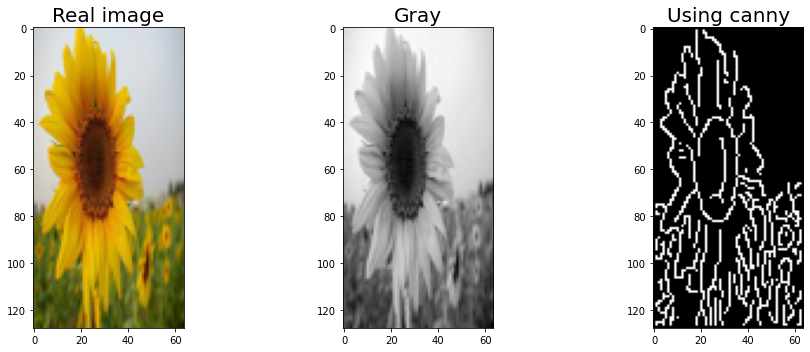

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(resized_image)
axes[1].imshow(gray_image, cmap=plt.cm.gray)
axes[2].imshow(gray_image_edges, cmap=plt.cm.gray)
ax_set_titles = [axes[i].set_title(title, fontsize=20) for i, title in enumerate(['Real image', 'Gray', 'Using canny'])]

plt.tight_layout()
plt.show()